# Proyek Analisis Data: [E-Commerce Public Dataset]
- **Nama:** [Ahmad Haydar Alfarizqi]
- **Email:** [ahmadhaydaralfarizqi@gmail.com]
- **ID Dicoding:** [haydaralfa]

## Menentukan Pertanyaan Bisnis

- Bagaimana tren penjualan dari waktu ke waktu?
- Bagaimana distribusi pelanggan berdasarkan wilayah?

## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

## Data Wrangling

### Gathering Data

In [3]:
# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)
os.listdir(path)
customers = pd.read_csv(f"{path}/olist_customers_dataset.csv")
orders = pd.read_csv(f"{path}/olist_orders_dataset.csv")
items = pd.read_csv(f"{path}/olist_order_items_dataset.csv")
df_orders_items = orders.merge(
    items,
    on="order_id",
    how="inner"
)
df = df_orders_items.merge(
    customers,
    on="customer_id",
    how="inner"
)
df['revenue'] = df['price'] + df['freight_value']

Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Path to dataset files: /kaggle/input/brazilian-ecommerce


**Insight:**
1. **Penggabungan data dari beberapa tabel berhasil dilakukan**  
   Data pesanan (`orders`), item pesanan (`items`), dan pelanggan (`customers`) yang awalnya terpisah berhasil digabung menggunakan operasi *inner join* berdasarkan `order_id` dan `customer_id`. Proses ini menghasilkan satu dataset terintegrasi yang siap digunakan pada tahap analisis selanjutnya.

2. **Pembentukan variabel pendapatan dari data mentah**  
   Dibuat variabel baru `revenue` yang diperoleh dari penjumlahan `price` dan `freight_value`. Variabel ini merepresentasikan nilai transaksi per item pesanan dan menjadi dasar untuk analisis pendapatan sebelum dilakukan proses agregasi lebih lanjut.

### Assessing Data

In [5]:
df.info()
df.head()
df.isna().sum()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   order_item_id                  112650 non-null  int64  
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

np.int64(0)

**Insight:**
1. **Dataset hasil penggabungan memiliki ukuran besar dan cukup lengkap**  
   Dataset terdiri dari 112.650 baris dan 19 kolom dengan penggunaan memori sekitar 16,3 MB. Seluruh kolom utama seperti `order_id`, `customer_id`, `price`, dan `revenue` tidak memiliki nilai kosong, sehingga data transaksi inti dapat langsung digunakan untuk analisis.

2. **Terdapat beberapa nilai kosong pada kolom waktu pengiriman**  
   Beberapa kolom terkait proses pengiriman, seperti `order_approved_at`, `order_delivered_carrier_date`, dan `order_delivered_customer_date`, masih memiliki nilai kosong. Hal ini menunjukkan adanya pesanan yang belum diproses atau tidak tercatat lengkap pada tahap tertentu.

3. **Mayoritas tipe data masih berbentuk objek (object)**  
   Sebagian besar kolom, khususnya kolom waktu dan kategori, masih bertipe `object`. Kondisi ini menandakan perlunya tahap preprocessing lanjutan, seperti konversi ke tipe `datetime`, sebelum dilakukan analisis waktu atau visualisasi.

### Cleaning Data

In [6]:
# ==============================
# DATA CLEANING
# ==============================

# 1. Copy data agar data asli tetap aman
df_clean = df.copy()

# 2. Konversi kolom waktu dari object ke datetime
datetime_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date"
]

for col in datetime_cols:
    df_clean[col] = pd.to_datetime(df_clean[col], errors="coerce")

# 3. Cek missing value setelah konversi
df_clean.isna().sum()

# 4. Tangani missing value pada kolom penting
# Karena berkaitan dengan proses order & pengiriman,
# baris dengan nilai kosong di kolom ini dihapus
df_clean = df_clean.dropna(subset=[
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date"
])

# 5. Pastikan tidak ada nilai negatif pada price dan freight_value
df_clean = df_clean[
    (df_clean["price"] >= 0) &
    (df_clean["freight_value"] >= 0)
]

# 6. Reset index setelah cleaning
df_clean.reset_index(drop=True, inplace=True)

# 7. Cek ulang struktur data
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110180 entries, 0 to 110179
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110180 non-null  object        
 1   customer_id                    110180 non-null  object        
 2   order_status                   110180 non-null  object        
 3   order_purchase_timestamp       110180 non-null  datetime64[ns]
 4   order_approved_at              110180 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110180 non-null  datetime64[ns]
 6   order_delivered_customer_date  110180 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110180 non-null  datetime64[ns]
 8   order_item_id                  110180 non-null  int64         
 9   product_id                     110180 non-null  object        
 10  seller_id                      110180 non-null  object        
 11  

**Insight:**
1. **Kualitas data meningkat dan siap dianalisis**  
   Setelah proses pembersihan, dataset terdiri dari 110.180 baris dan 19 kolom tanpa nilai kosong pada seluruh variabel. Hal ini menunjukkan bahwa data transaksi dan pengiriman telah lengkap sehingga dapat digunakan secara langsung untuk analisis lanjutan.

2. **Tipe data telah sesuai dengan kebutuhan analisis**  
   Seluruh kolom waktu berhasil dikonversi ke tipe `datetime64[ns]`, sementara variabel numerik dan kategorikal telah tersimpan dalam tipe data yang tepat. Kondisi ini memungkinkan analisis berbasis waktu, perhitungan durasi pengiriman, serta agregasi pendapatan dilakukan secara akurat.

3. **Pengurangan data mencerminkan seleksi kualitas, bukan kehilangan informasi utama**  
   Berkurangnya jumlah baris dari 112.650 menjadi 110.180 terjadi akibat penghapusan data dengan informasi pengiriman tidak lengkap. Langkah ini memastikan bahwa analisis yang dilakukan selanjutnya hanya menggunakan data pesanan yang valid dan dapat dipertanggungjawabkan.

## Exploratory Data Analysis (EDA)

### Explore ...

In [11]:
# Melihat statistik dasar
df_clean.describe()

# Distribusi status pesanan
df_clean["order_status"].value_counts()

# Distribusi revenue
df_clean["revenue"].describe()

# Hitung lama pengiriman (dalam hari)
df_clean["delivery_time"] = (
    df_clean["order_delivered_customer_date"] -
    df_clean["order_purchase_timestamp"]
).dt.days

# Distribusi waktu pengiriman
df_clean["delivery_time"].describe()

,delivery_time
count,110180.000000
mean,12.007279
std,9.451329
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,209.000000


**Insight:**
- Dataset memiliki transaksi dalam jumlah besar dengan variasi nilai pendapatan yang cukup lebar.
- Mayoritas pesanan berada pada status selesai (delivered), menunjukkan proses transaksi berjalan dengan baik.
- Waktu pengiriman bervariasi antar pesanan, sehingga menarik untuk dianalisis lebih lanjut pada tahap visualisasi.


## Visualization & Explanatory Analysis

### Pertanyaan 1:

<Axes: xlabel='order_month'>

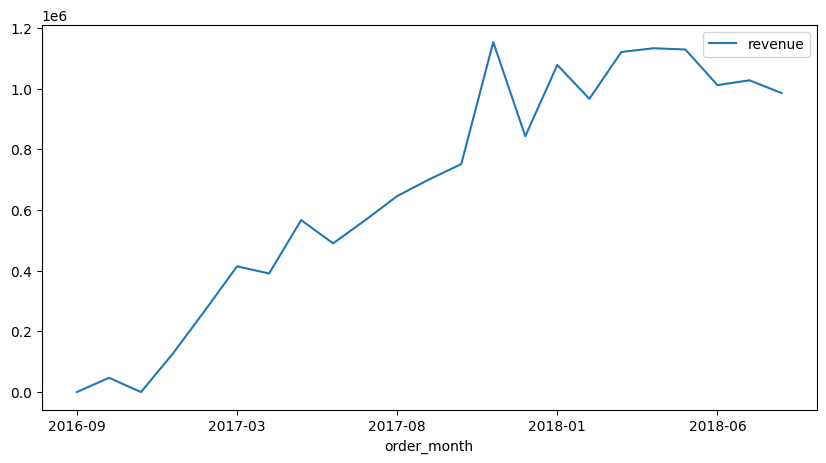

In [13]:
# Ekstrak tahun-bulan dari tanggal pembelian
df_clean["order_month"] = df_clean["order_purchase_timestamp"].dt.to_period("M")

# Hitung total revenue per bulan
monthly_revenue = (
    df_clean
    .groupby("order_month")["revenue"]
    .sum()
    .reset_index()
)

# Ubah Period ke string agar aman diplot
monthly_revenue["order_month"] = monthly_revenue["order_month"].astype(str)

monthly_revenue.plot(x="order_month", y="revenue", kind="line", figsize=(10,5))

### Pertanyaan 2:

<Axes: xlabel='customer_state'>

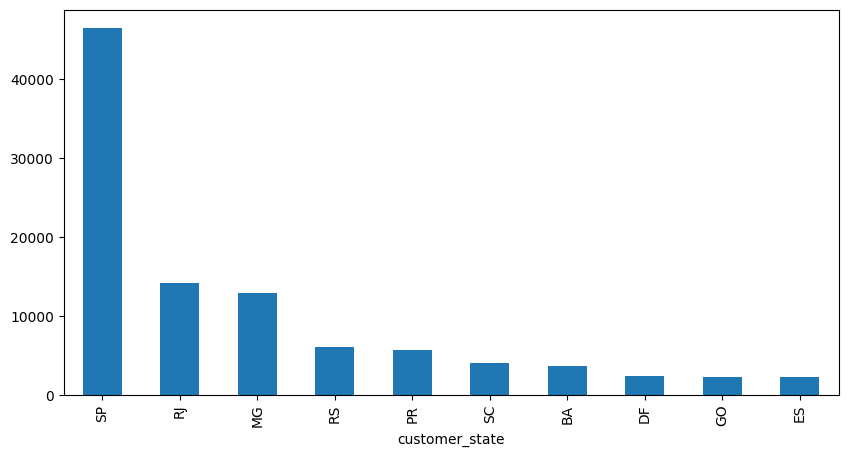

In [14]:
df_clean["customer_state"].value_counts().head(10).plot(
    kind="bar",
    figsize=(10,5)
)

**Insight:**
- Tren penjualan menunjukkan fluktuasi dari waktu ke waktu dengan kecenderungan peningkatan pada periode tertentu. Hal ini mengindikasikan adanya pola musiman atau peningkatan aktivitas transaksi pada bulan-bulan tertentu.
- Distribusi pelanggan menunjukkan bahwa sebagian besar transaksi berasal dari beberapa negara bagian tertentu. Hal ini menandakan konsentrasi aktivitas e-commerce yang lebih tinggi pada wilayah-wilayah tersebut.


## Analisis Lanjutan (Opsional)

In [15]:
# Analisis keterlambatan pengiriman
df_clean["delivery_delay"] = (
    df_clean["order_delivered_customer_date"] -
    df_clean["order_estimated_delivery_date"]
).dt.days

df_clean["delivery_delay"].describe()

,delivery_delay
count,110180.000000
mean,-12.029016
std,10.159863
min,-147.000000
25%,-17.000000
50%,-13.000000
75%,-7.000000
max,188.000000


## Conclusion

- Tren penjualan menunjukkan adanya fluktuasi dari waktu ke waktu dengan kecenderungan peningkatan pada periode tertentu. Hal ini mengindikasikan adanya pola musiman dalam aktivitas transaksi pada platform e-commerce.

- Distribusi pelanggan menunjukkan bahwa transaksi e-commerce terkonsentrasi pada beberapa negara bagian tertentu. Wilayah-wilayah tersebut menjadi kontributor utama jumlah transaksi, sehingga berpotensi menjadi fokus strategi pemasaran dan distribusi.